In [1]:
import pandas as pd
from datetime import datetime
from lib_descriptive import plot_histograms
from lib_data import fetch_data, fetch_spot_prices
from lib_predictive import preprocess_data, split_data, normalize_data, reshape_data_LSTM, train_lstm_model, evaluate_model, predict_future, load_model

2024-12-28 19:25:21.015070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735410321.036533   31308 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735410321.042345   31308 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 19:25:21.065709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# asof = datetime.combine(datetime.now(), time.min)
asof = datetime(2024, 12, 1)
start_date = datetime(2020, 1, 1)
API_KEY = 'YOUR_DMI_API_KEY'
STATION_ID = '06030'  # Aalborg weather station
LAT, LON = 57.048, 9.9187 # Coordinates for Aalborg

In [4]:
historical_spot_prices = fetch_spot_prices(start_date, asof)
historical_wind_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'wind_speed', STATION_ID, API_KEY, historical=True)
historical_temp_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'temp_dry', STATION_ID, API_KEY, historical=True)

In [5]:
df = preprocess_data(historical_spot_prices, historical_wind_data, historical_temp_data)

In [6]:
features = ['day_of_year','weekday' ,'hour' ,'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'wind_speed', 'temperature','epoch']
target = 'PriceEUR'

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, features, target)

In [7]:
# dont need to normalize data for LSTM, probably
X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = normalize_data(X_train, X_val, X_test, y_train, y_val, y_test)

In [8]:
print(X_train)

[[0.00000000e+00 3.33333333e-01 0.00000000e+00 ... 2.92743953e-01
  3.65887687e-01 0.00000000e+00]
 [0.00000000e+00 3.33333333e-01 4.34782609e-02 ... 3.17764804e-01
  3.91349843e-01 3.30250991e-05]
 [0.00000000e+00 3.33333333e-01 8.69565217e-02 ... 3.26939116e-01
  3.96232996e-01 6.60501981e-05]
 ...
 [4.52054795e-01 5.00000000e-01 6.08695652e-01 ... 1.71809842e-01
  7.97349145e-01 9.99933950e-01]
 [4.52054795e-01 5.00000000e-01 6.52173913e-01 ... 1.84320267e-01
  7.87582839e-01 9.99966975e-01]
 [4.52054795e-01 5.00000000e-01 6.95652174e-01 ... 1.80150125e-01
  7.77118940e-01 1.00000000e+00]]


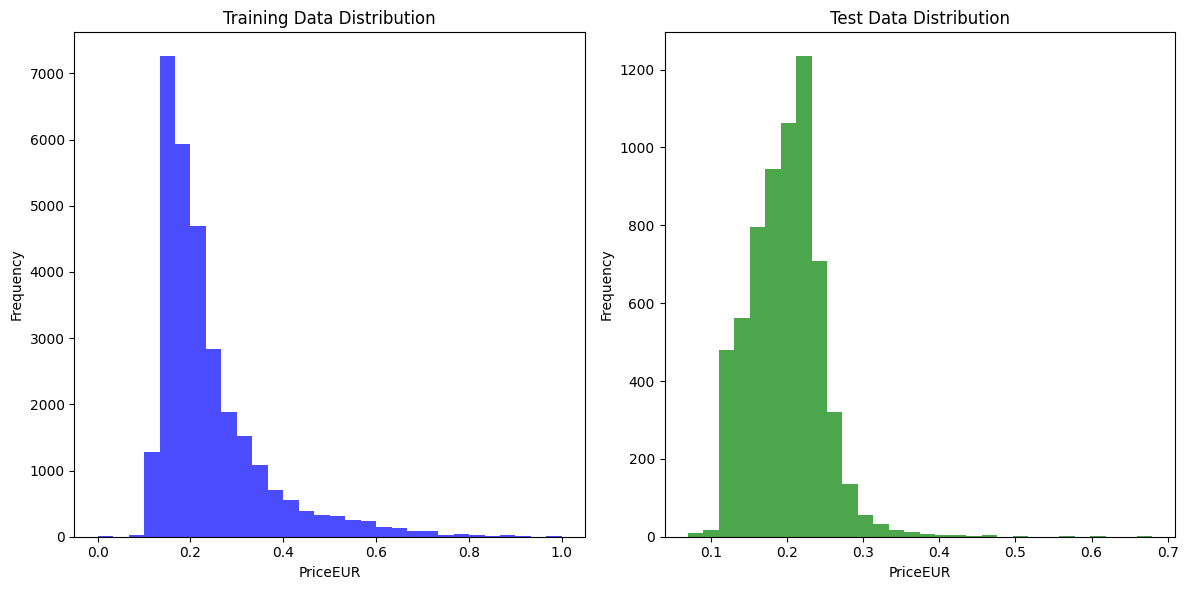

In [9]:
plot_histograms(y_train, y_test)

In [10]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(29920, 10) (6411, 10) (6412, 10)
(29920, 1) (6411, 1) (6412, 1)


In [11]:
# Reshape data for LSTM
X_train, X_val, X_test = reshape_data_LSTM(X_train, X_val, X_test)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(29920, 1, 10) (6411, 1, 10) (6412, 1, 10)
(29920, 1) (6411, 1) (6412, 1)


In [12]:
# Train LSTM model
model, history = train_lstm_model(X_train, y_train, X_val, y_val)

I0000 00:00:1735410326.279308   31308 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4093 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


I0000 00:00:1735410329.998976   31350 service.cc:148] XLA service 0x7f194800baf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735410329.999099   31350 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2024-12-28 19:25:30.047935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735410330.331748   31350 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1735410332.198656   31350 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 - 9s - 39ms/step - loss: 0.0111 - val_loss: 0.0018
Epoch 2/20
234/234 - 2s - 8ms/step - loss: 0.0089 - val_loss: 0.0016
Epoch 3/20
234/234 - 2s - 7ms/step - loss: 0.0086 - val_loss: 0.0016
Epoch 4/20
234/234 - 2s - 7ms/step - loss: 0.0086 - val_loss: 0.0016
Epoch 5/20
234/234 - 2s - 8ms/step - loss: 0.0088 - val_loss: 0.0017
Epoch 6/20
234/234 - 2s - 9ms/step - loss: 0.0090 - val_loss: 0.0020
Epoch 7/20
234/234 - 2s - 8ms/step - loss: 0.0092 - val_loss: 0.0026
Epoch 8/20
234/234 - 2s - 7ms/step - loss: 0.0097 - val_loss: 0.0032
Epoch 9/20
234/234 - 2s - 8ms/step - loss: 0.0100 - val_loss: 0.0041
Epoch 10/20
234/234 - 2s - 7ms/step - loss: 0.0103 - val_loss: 0.0049
Epoch 11/20
234/234 - 2s - 8ms/step - loss: 0.0105 - val_loss: 0.0058
Epoch 12/20
234/234 - 2s - 7ms/step - loss: 0.0107 - val_loss: 0.0067
Epoch 13/20
234/234 - 2s - 7ms/step - loss: 0.0109 - val_loss: 0.0072
Epoch 14/20
234/234 - 2s - 7ms/step - loss: 0.0109 - val_loss: 0.0077
Epoch 15/20
234/234 - 2s - 7ms/step - l

201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean Absolute Error: 0.10 EUR


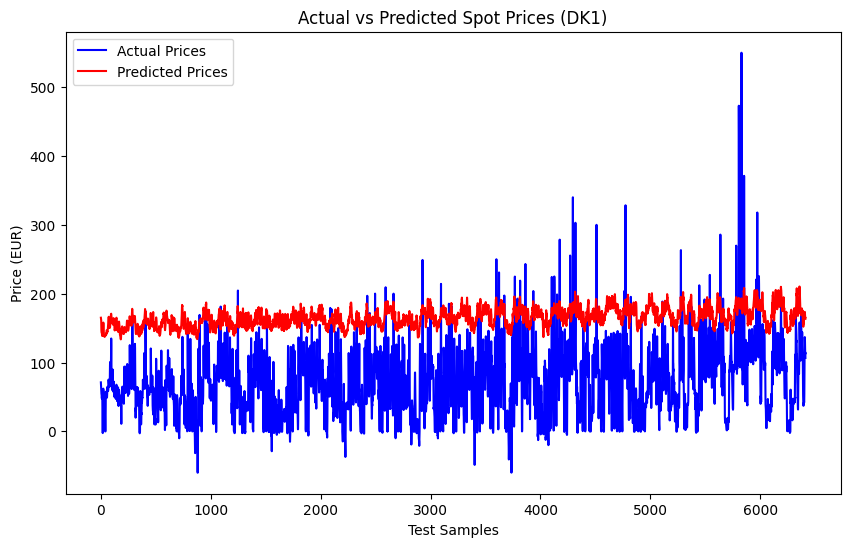

In [13]:
from lib_descriptive import plot_predictions


predictions = evaluate_model(model, X_test, y_test)
scaled_predictions = scaler_y.inverse_transform(predictions)
scaled_y_test = scaler_y.inverse_transform(y_test)
plot_predictions(scaled_y_test, scaled_predictions)

In [14]:
# Load the model for future predictions
# model = load_model('lstm_model.keras')

201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


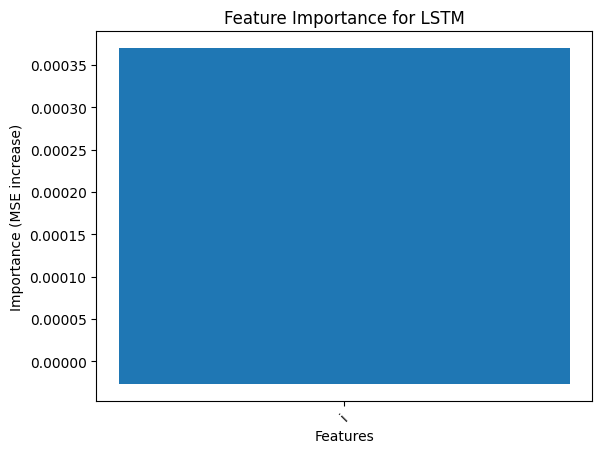

In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
baseline_mse = mean_squared_error(y_test, model.predict(X_test))

def permutation_importance(model, X_test, y_test, baseline_mse):
    importances = []
    for feature in range(X_test.shape[2]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, :, feature])  # Shuffle one feature at a time
        mse = mean_squared_error(y_test, model.predict(X_permuted))
        importances.append(mse - baseline_mse)
    return importances

# Compute feature importances
importances = permutation_importance(model, X_test, y_test, baseline_mse)

# Assuming feature names are available
feature_names = features
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance (MSE increase)')
plt.title('Feature Importance for LSTM')
plt.xticks(rotation=45)
plt.show()

In [16]:
future_df, predictions = predict_future(model, asof)


2024-12-28 19:26:15.998101: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,8], In[1]: [10,200]

Stack trace for op definition: 
File "usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "usr/lib/python3.10/runpy.py", line 86, in _run_code
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
File "usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "usr/lib/python3.10/a

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/lstm_1/lstm_cell_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [32,8], In[1]: [10,200]

Stack trace for op definition: 
File "usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "usr/lib/python3.10/runpy.py", line 86, in _run_code
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
File "usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
File "tmp/ipykernel_31308/3174379331.py", line 1, in <module>
File "home/sobibence/AAU/3_semester/project/psa_tool/lib_predictive.py", line 154, in predict_future
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 559, in predict
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 256, in one_step_on_data_distributed
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 246, in one_step_on_data
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 101, in predict_step
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/models/sequential.py", line 213, in call
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 182, in call
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/models/functional.py", line 632, in call
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 570, in call
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 402, in call
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 565, in inner_loop
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 342, in inner_loop
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 262, in rnn
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 334, in step
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/layer.py", line 899, in __call__
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 264, in call
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 3759, in matmul
File "home/sobibence/AAU/3_semester/project/psa_tool/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 501, in matmul

	 [[{{node sequential_1/lstm_1/lstm_cell_1/MatMul}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_23877[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_23892]

In [ ]:
print(future_df)
print(predictions)